# Digit Recognizer by CNN

`CNN` 训练识别手写数字体

`Accuracy:` 98.81%

---

Created on 2019-05-26

Update  on 2019-05-26

Author: 家丞

Github: https://github.com/Jiachengciel/Kaggle

---

##  一. 基础环境配置

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import time

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

---

## 二. 数据分析

### 2.1 导入数据

In [2]:
# Load the data
train = pd.read_csv('input/train.csv')

# classify the data
Y_train = train.label
X_train = train.drop(labels = ['label'], axis=1)

# free some space
del train

print("Quantity of examples: {}\nX size:{}". format(X_train.shape[0], X_train.shape))


Quantity of examples: 42000
X size:(42000, 784)


### 2.2 数据可视化

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

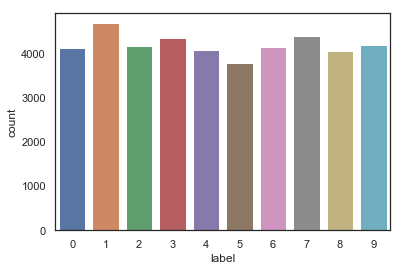

In [3]:
# visualize the data
g = sns.countplot(Y_train)
Y_train.value_counts()

---

## 三. 特征工程

### 3.1 检查缺失值

In [4]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

### 3.2 标准化

In [5]:
X_np = X_train.values / 255.0
Y_np = Y_train.values

### 3.3 矩阵格式改变

In [6]:
X_train = X_np.reshape(-1, 1, 28, 28)
print("X_train shape: ", X_train.shape)

X_train shape:  (42000, 1, 28, 28)


### 3.4 将标签变为one-hot编码

In [7]:
# Y_tensor = torch.LongTensor(Y_np).view(-1,1)
# Y_onehot = torch.FloatTensor(Y_np.size, 10)
# Y_onehot.zero_()
# Y_onehot.scatter_(1, Y_tensor, 1)
# Y_onehot = Y_onehot.numpy()

# print("Y_onehot shape: ", Y_onehot.shape)
# # 查看one-hot例子
# print(Y_onehot[0])

### 3.4 分割训练集和交叉训练集

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_np, 
                                                 test_size=0.2,
                                                 random_state=2)


### 3.5 转换为Tensor格式

In [9]:
X_Train = torch.from_numpy(X_train)
Y_Train = torch.from_numpy(Y_train).type(torch.LongTensor)

X_Test = torch.from_numpy(X_test)
Y_Test = torch.from_numpy(Y_test).type(torch.LongTensor)

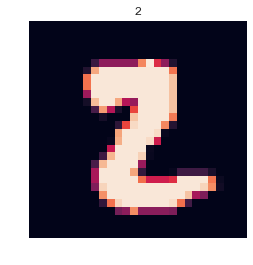

In [10]:
# 可视化
plt.imshow(X_np[16].reshape(28,28))
plt.axis('off')
plt.title(str(Y_np[16]))
plt.show()

---

## 四. 模型选择与使用

### 4.1 设定初始参数

In [11]:
BATCH_SIZE = 100
EPOCH = 15
LEARING_RATE = 0.001

### 4.2 载入数据

In [12]:
train = torch.utils.data.TensorDataset(X_Train, Y_Train)
test = torch.utils.data.TensorDataset(X_Test, Y_Test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE,shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)


### 4.3 定义模型

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 
        #-> Flatten -> Dense -> Dropout -> Dense Out
        self.cnn1 = nn.Sequential(
            # 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2),
            
            nn.Dropout(0.25),
            # （14*14*32）
        )
        self.cnn2 =nn.Sequential(
            # 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Dropout(0.25),
            # (7*7*64)
        )
        
        self.dense1 = nn.Sequential(
            nn.Linear(7*7*64, 256),
            nn.ReLU(),
        )
        
        self.dropout= nn.Dropout(0.5)
        
        self.dense2 = nn.Sequential(
            nn.Linear(256, 10)
#             nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        # Convolution
        Convolution1 = self.cnn1(x)
        
        Convolution2 = self.cnn2(Convolution1)
        
        # Flatten
        Flatten = Convolution2.view(Convolution2.size(0), -1)
        
        # Dense1
        dense1 = self.dense1(Flatten)
        
        # Dropout
        drop = self.dropout(dense1)
        
        # Dense2
        out = self.dense2(drop)
        
        return out
    
model = CNN()
error = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARING_RATE, betas=(0.9, 0.99))

print(model)

CNN(
  (cnn1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25)
  )
  (cnn2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25)
  )
  (dense1): Sequential(
    (0): Linear(in_features=3136, out_features=256, bias=True)
    (1): ReLU()
  )
  (dropout): Dropout(p=0.5)
  (dense2): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
  )
)


### 4.4 训练模型

In [14]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
start = time.clock()

for epoch in range(EPOCH):
    for steps, (images, labels) in enumerate(train_loader):
        
        train = Variable(images)
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train.float())
        
        # Calculate softmax
        loss = error(outputs, labels)
        
        # Backward
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1

        if count % 50 == 0:
            # Calculate accuracy
            correct = 0
            
            for images, labels in test_loader:
                test = Variable(images)
                
                outputs = model(test.float())
                
                predicted = torch.max(outputs.data, 1)[1]
                
                correct += (predicted == labels).sum()
            
            accuracy = round(float(100 * correct.item() / float(X_test.shape[0])), 2)
            
            # Store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
            if count % 500 == 0:
                print('Iteration: {} Loss: {} Accuracy: {} %'.format(count, loss.data, accuracy))
                
end = time.clock()
print("运行时间：{} s".format(end-start))


Iteration: 500 Loss: 0.05874874070286751 Accuracy: 96.99 %
Iteration: 1000 Loss: 0.0877520963549614 Accuracy: 97.83 %
Iteration: 1500 Loss: 0.023887798190116882 Accuracy: 98.24 %
Iteration: 2000 Loss: 0.0023048019502311945 Accuracy: 98.49 %
Iteration: 2500 Loss: 0.008627302944660187 Accuracy: 98.65 %
Iteration: 3000 Loss: 0.0018544053891673684 Accuracy: 98.5 %
Iteration: 3500 Loss: 0.002097429009154439 Accuracy: 98.56 %
Iteration: 4000 Loss: 0.02700969949364662 Accuracy: 98.69 %
Iteration: 4500 Loss: 0.009593057446181774 Accuracy: 98.89 %
Iteration: 5000 Loss: 0.013261007145047188 Accuracy: 98.81 %
运行时间：8397.248325 s


### 4.5 可视化训练过程

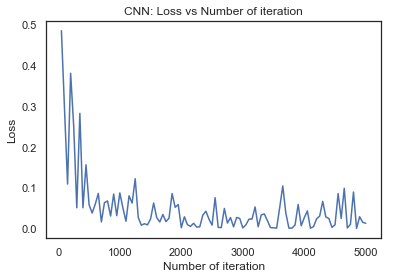

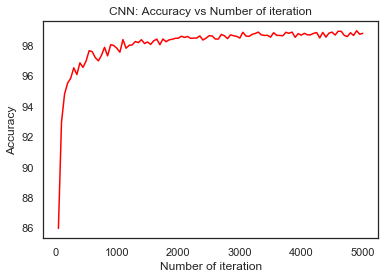

In [15]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()